In [34]:
import numpy as np
from numpy import array, sqrt
from hw import Henrard, Jamshidian, hw_helper 
from fox_toolbox.utils import xml_parser, rates, volatility
from mc import mc

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (20, 10.)})
sns.set_style("whitegrid")


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
paths = 1000
timestep = 500
x0 = 0.

np.random.seed(26)

In [36]:


OUTPUT_5SWO, INPUT_5SWO = xml_parser.get_files('hw xml', 'kos_test')
_, irsmout = xml_parser.get_xml(OUTPUT_5SWO)

ref_mr, (hw_buckets, hw_sigma) = xml_parser.get_hw_params(irsmout)
ref_sigmas = rates.Curve(hw_buckets, hw_sigma, 'PieceWise')

T = ref_sigmas.buckets[-1]
T = 6.0
U = T 
tt = array( [round(x,2) for x in np.linspace(0, T, timestep+1, endpoint = True)] )

In [37]:
ref_sigmas = rates.Curve(array([ 0., 10.]), array([0.08, 0.08]), 'PieceWise', '')

T-forward diffusion
<font size="5">
$X_{t+1} = X_t - \boxed{B(t, T) \sigma^{2} dt} - aX_tdt + \sigma_t\sqrt{dt} \xi$
    </font>

In [43]:
sigma = ref_sigmas
mr = ref_mr; a = mr;
hw = mc.HullWhiteProcess( mr = ref_mr, sigma = ref_sigmas, x0 = x0, measure = 'terminal')
exact_df, (euler_df, euler_drift_df, exact_drift_df, drift_T_cumsum_df) = hw.generate_paths(until=T, timestep=timestep, paths=paths, info=True)

## OPEN QUESTION: get_drift_T is not addetive. Should it be?


In [44]:
sum1 = 0
for t1, t2 in zip(tt[:-1], tt[1:]):
    sum1+= hw_helper.get_drift_T(t1, t2, T, ref_mr, sigma)
    
sum1, hw_helper.get_drift_T(0, T, T, ref_mr , sigma)

(0.10445979444996766, 0.08598424925515602)

<font size = 4>
Indeed it is not additive, $x_s e^{-a (t-s)}$ should compensate this non-additivity

<font size="5">
$X_{T}=e^{-a(T-t)} X_{t} - \boxed{M^{T^*}(t,T)} +\int_{t}^{T} e^{-a(T-s)} \sigma_{s} d W_{s}$ <br>
</font>

In [45]:
def drift_const(s, t, U, mr):
    p1 = 1.0 - np.exp(-mr * (t - s))
    p2 = np.exp(-mr * (U - t)) - np.exp(-mr * (U + t- 2 * s))
    return (1/mr) ** 2 * (p1 - p2 / 2.0)

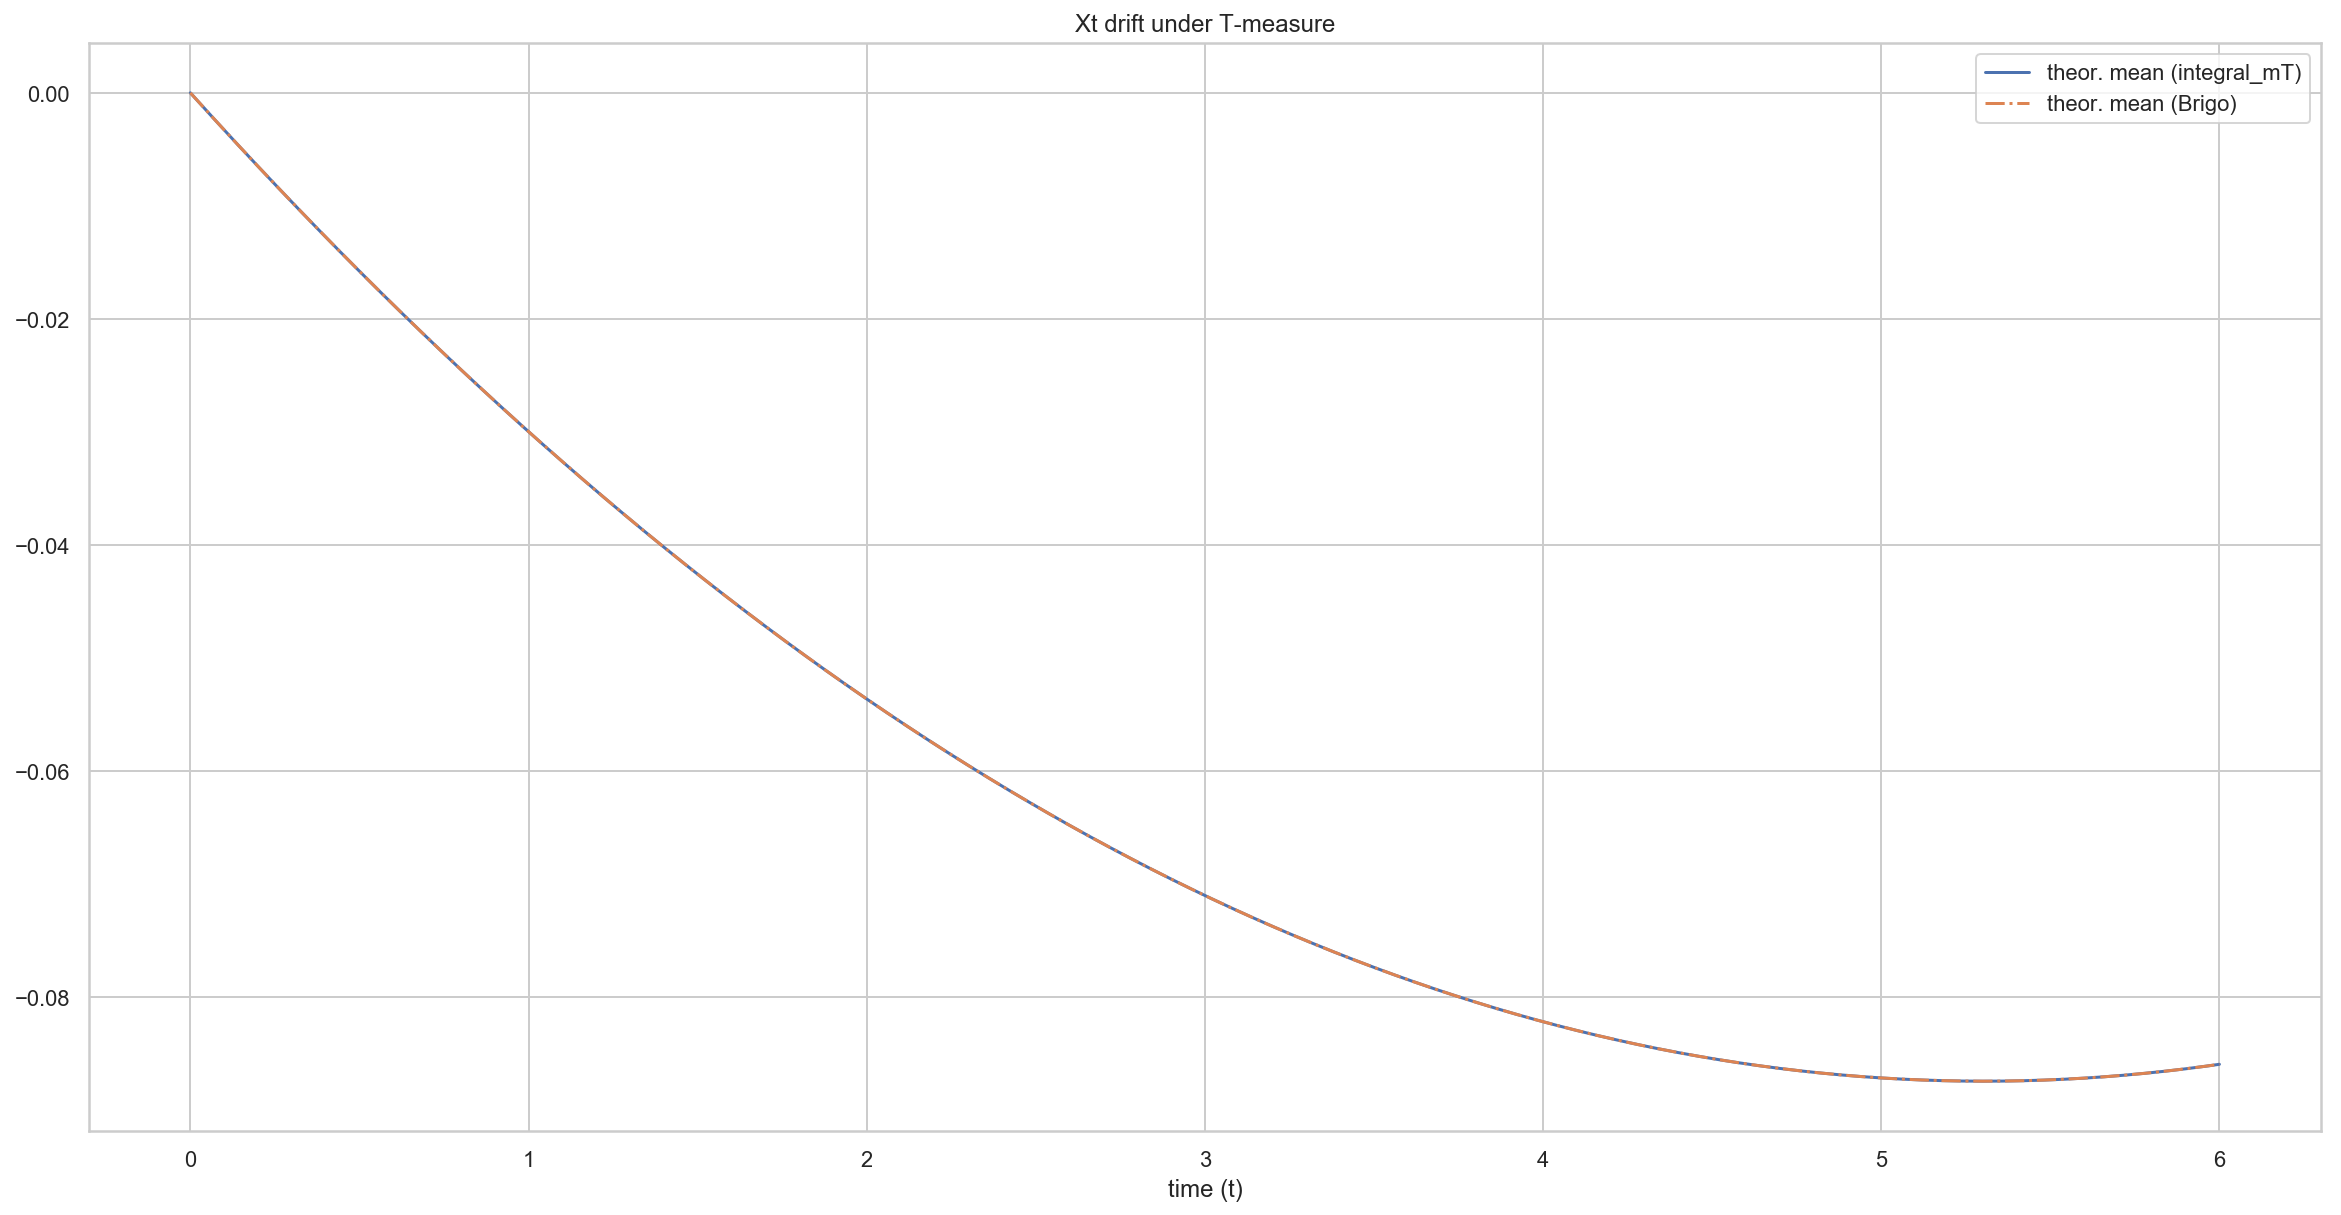

In [46]:
plt.plot(tt, [ -hw.drift_T(0, t, U=T) for t in tt], label = 'theor. mean (integral_mT)');
plt.plot(tt, -drift_const(0.0, tt, T, ref_mr) * sigma(0)**2, label = 'theor. mean (Brigo)', ls='-.');
plt.title('Xt drift under T-measure'); plt.xlabel('time (t)'); plt.legend()

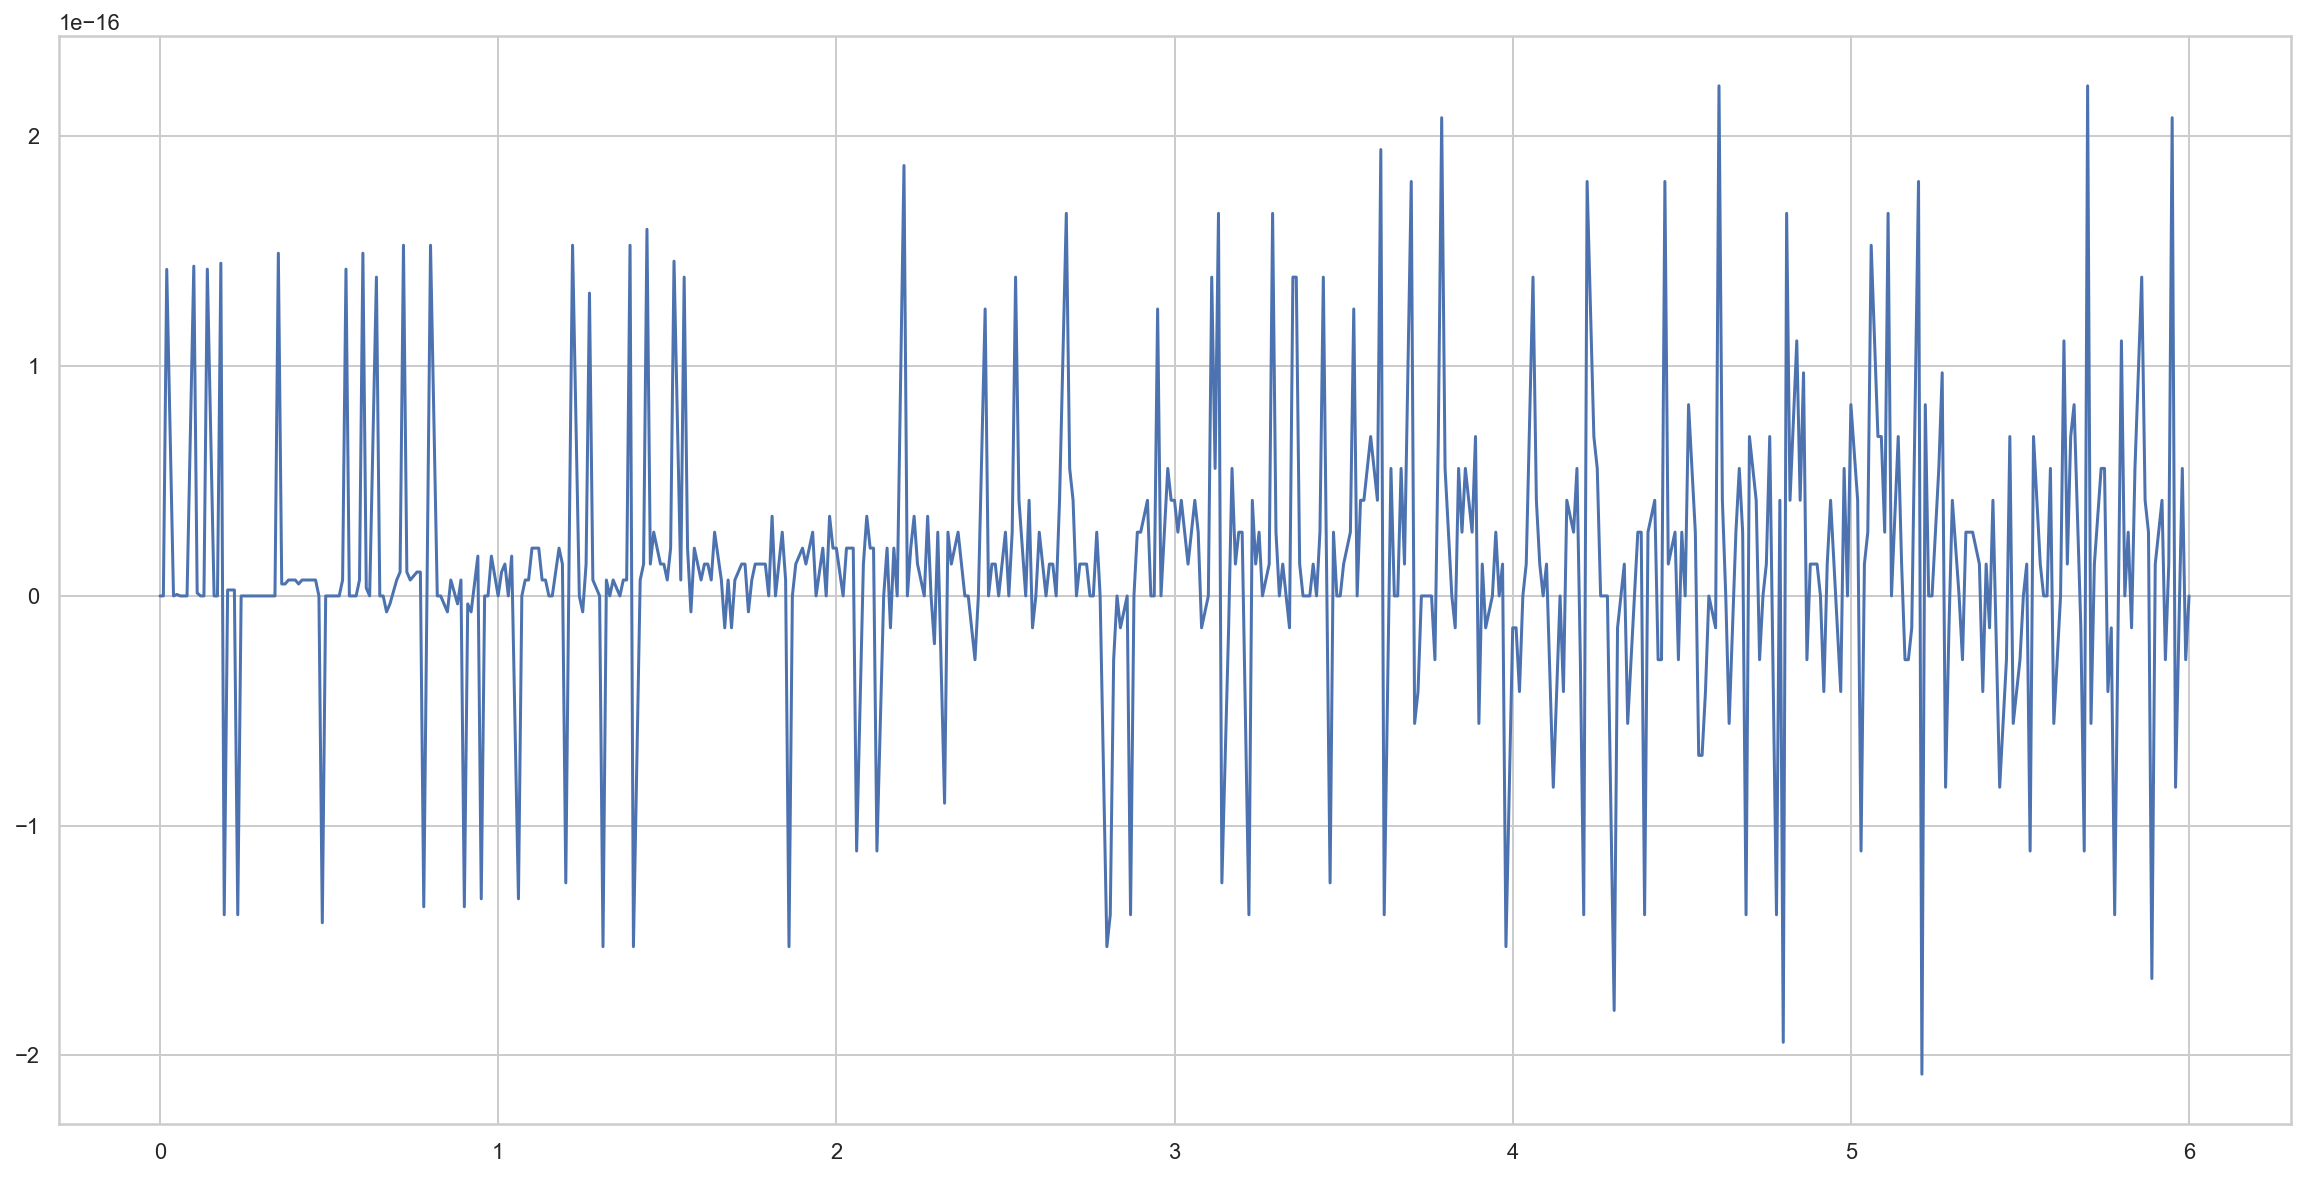

In [31]:
plt.plot(tt, array([ -hw.drift_T(0, t, U=T) for t in tt]) + drift_const(0.0, tt, T, ref_mr) * sigma(0)**2)

## Realized Xt average

In [32]:
euler_realized_mean  = array([euler_df.loc[t].mean() for t in euler_df.index])
numerical_euler_mean = array([euler_numerical_drift_df.loc[t].mean() for t in euler_numerical_drift_df.index])

numerical_exact_mean = array([exact_drift_df.loc[t].mean() for t in exact_df.index])
numerical_drift_T    = array([numerical_drift_df.loc[t].mean() for t in numerical_drift_df.index])
numerical_exact     = array([exact_df.loc[t].mean() for t in numerical_drift_df.index])

brifo_drift = -drift_const(0.0, tt, T, ref_mr) * sigma(0)**2

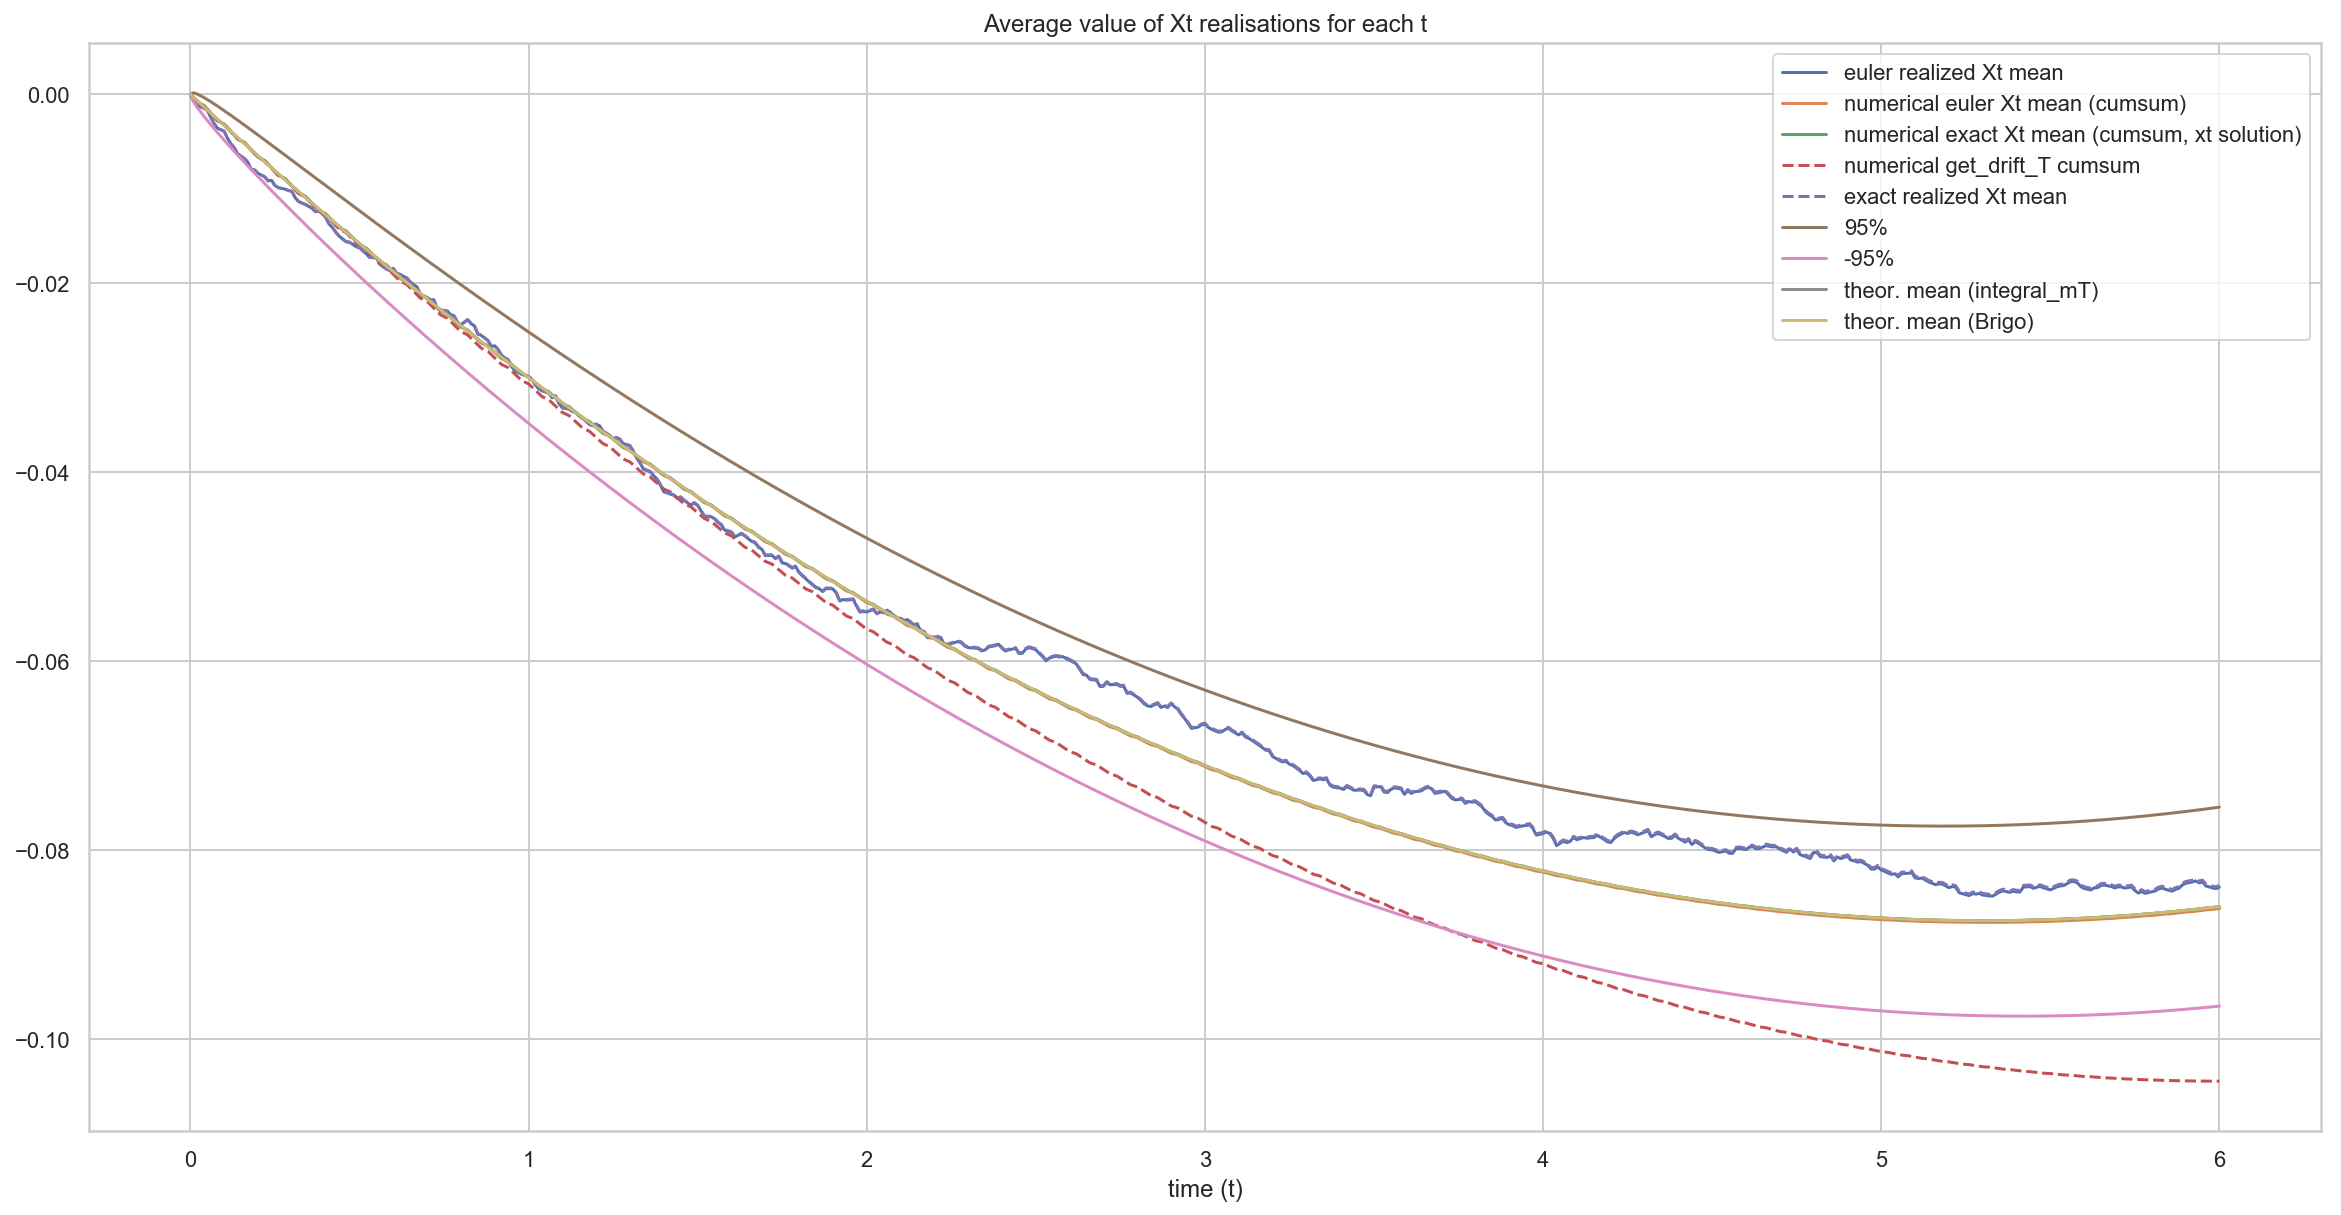

In [33]:
plt.plot(tt, euler_realized_mean,  label = 'euler realized Xt mean');
plt.plot(tt, numerical_euler_mean, label = 'numerical euler Xt mean (cumsum)');

plt.plot(tt, numerical_exact_mean, label = 'numerical exact Xt mean (cumsum, xt solution)');
plt.plot(tt, numerical_drift_T, label = 'numerical get_drift_T cumsum', ls='--');
plt.plot(tt, numerical_exact, label = 'exact realized Xt mean', ls='--');


plt.plot(tt, [ -hw.drift_T(0, t, U=T) + 1.96 * sqrt(Jamshidian.get_var_x(t, ref_mr, sigma) / spotstep) for t in tt], label = '95%');
plt.plot(tt, [ -hw.drift_T(0, t, U=T) - 1.96 * sqrt(Jamshidian.get_var_x(t, ref_mr, sigma) / spotstep) for t in tt], label = '-95%');
plt.plot(tt, [ -hw.drift_T(0, t, U=T) for t in tt], label = 'theor. mean (integral_mT)');
plt.plot(tt, brifo_drift, label = 'theor. mean (Brigo)');
plt.title('Average value of Xt realisations for each t'); plt.xlabel('time (t)'); plt.legend()

Interesting things: 
- Euler realized Xt mean coinsides with numerical exact Xt mean => Xt solution is correct
- numerical get_drift_T cumsum doesnt coinside with theoretical because of $X_s$ mean reversion: 
<font size = 4>
$\mathbb{E}[X_t] = X_s \boxed{ e^{-a (t-s)}} - M^T(s,t)$ 
<br>
- "numerical exact Xt mean (xt solution)" consides with theoretical (integra_mT) mean => realized drift is aligned with theor. SDE solution

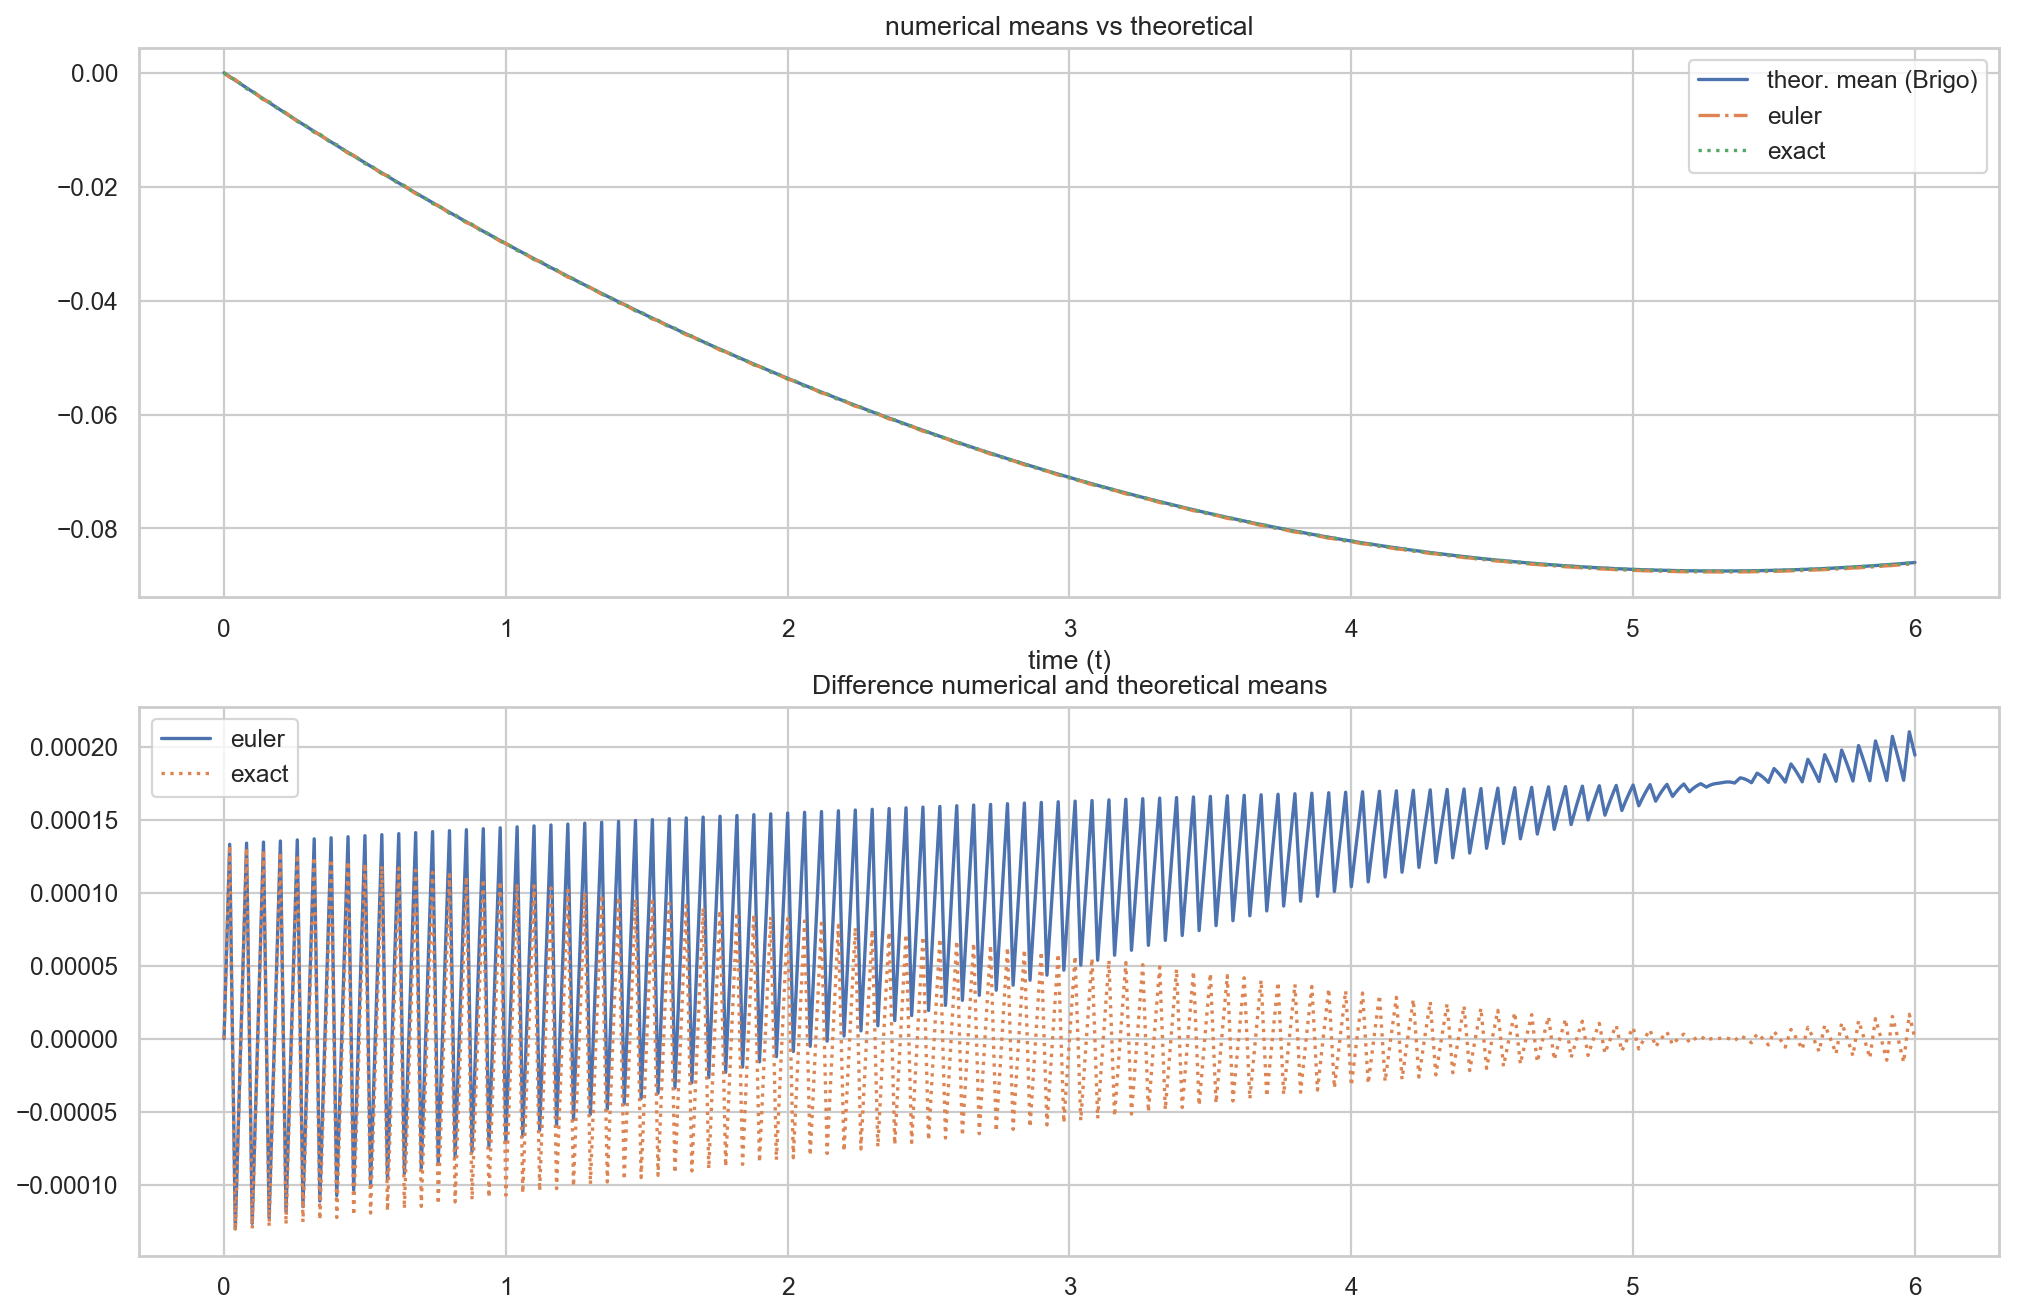

In [94]:
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2, 1, 1);
plt.plot(tt, brifo_drift, label = 'theor. mean (Brigo)');
plt.plot(tt, numerical_euler_mean, label = 'euler', ls='-.');
plt.plot(tt, numerical_exact_mean, label = 'exact', ls=':');
plt.title('numerical means vs theoretical'); plt.xlabel('time (t)'); plt.legend()

plt.subplot(2, 1, 2);
plt.plot(tt, brifo_drift - numerical_euler_mean, label = 'euler', ls='-' )
plt.plot(tt, brifo_drift - numerical_exact_mean , label = 'exact', ls=':')
plt.title('Difference numerical and theoretical means'); plt.legend();

Interesting thing: with timestep = 100, Euler diverges from theoretical mean (and bigger time is, big spread is). <br>
Then if we raise the timestep, the convergence looks nice (1e-7) but the shape is quite weird

### Realized $X_t$ standard deviation (independent of measure)

<font size = 5>
$X_{\mathrm{t}} \sim \mathcal{N}\left(0, \int_{\mathrm{0}}^{\mathrm{t}} \mathrm{e}^{-2 \mathrm{a}(\mathrm{t}-\mathrm{s})} \sigma_{\mathrm{s}}^{2} \mathrm{d} \mathrm{s}\right)$ <br>
    

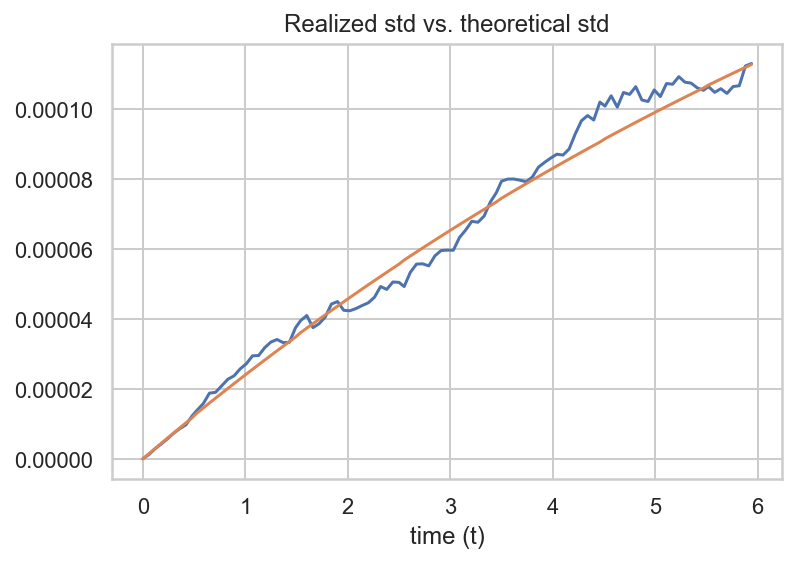

In [29]:
plt.plot(tt, [df.loc[t].std()**2 for t in df.index]);
plt.plot(tt, [Jamshidian.get_var_x(t, mr, sigma) for t in df.index]);
plt.title('Realized std vs. theoretical std'); plt.xlabel('time (t)');

In [ ]:
import ipywidgets as widgets

In [ ]:
tab_contents = ['P0', 'P1', 'P2', 'P3', 'P4']
children = [widgets.Text(description=name) for name in tab_contents]
tab = widgets.Tab()
tab.children = children
tab.titles = [str(i) for i in range(len(children))]
tab

In [ ]:
widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def f(x):
    return x

interact(f, x=xx);

7

In [ ]:
1+1